In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyfftw.interfaces.scipy_fftpack import rfft, rfftfreq, irfft

import os
from multiprocessing import cpu_count

import numba

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)

In [2]:
MOTION_SENSOR_COLUMNS = ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 
                         'gravity.x', 'gravity.y', 'gravity.z', 
                         'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 
                         'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

In [3]:
def denoise_data(data_frame, sampling_rate = 30):
    for reading in MOTION_SENSOR_COLUMNS:
        xf = rfftfreq(len(data_frame), 1 / sampling_rate)
        
        yf = rfft(data_frame[reading].to_numpy())
        
        #maximum frequency magnitude
        max_magnitude = np.amax(yf)

        yf[yf < 0.6 * max_magnitude] = 0

        new_reading = irfft(yf)

        data_frame[reading] = new_reading
    return

In [4]:
def load_raw_data(dataset_path, denoise = False):
    """
    Load data from csv files, denoise data from each file and concatenate all data into one data frame
    """
    
    # Load data from sensor:
    dirs = os.listdir(dataset_path)
    dfs = []
    for d in dirs:
        activity_name, experiment_id = d.split("_")
        for subject in os.listdir(os.path.join(dataset_path, d)):
            filepath = os.path.join(os.path.join(dataset_path, d), subject)
            
            df = pd.read_csv(filepath, index_col=0)
            
            if denoise:
                denoise_data(df)
            
            df['subject'] = int(subject.split(".")[0].split("_")[1]) # keep only the subject's numerical i.d.
            df['activity'] = activity_name
            df['experiment_id'] = int(experiment_id)
            df['experiment_step'] =  np.arange(0, len(df)) # assign a numerical step number for every measurement in the experiment
            dfs.append(df)

    final_df = pd.concat(dfs)

    return final_df

In [5]:
dataset_path = r"./A_DeviceMotion_data/A_DeviceMotion_data"

raw_df = load_raw_data(dataset_path)

denoised_df = load_raw_data(dataset_path, denoise=True)

In [6]:
def plot_experiment_in_time_domain(df1, df2, subject, experiment_id):
    df1 = df1.loc[(df1['subject'] == subject) & (df1['experiment_id'] == experiment_id)]
    df2 = df2.loc[(df2['subject'] == subject) & (df2['experiment_id'] == experiment_id)]

    ATTITUDE_COLUMNS = ['attitude.roll', 'attitude.pitch', 'attitude.yaw']
    GRAVITY_COLUMNS = ['gravity.x', 'gravity.y', 'gravity.z']
    ROTATION_RATE_COLUMNS = ['rotationRate.x', 'rotationRate.y', 'rotationRate.z']
    ACCELERATION_COLUMNS = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

    title1 = str.format("Subject {} Experiment {}_{} (Raw)", subject, df1['activity'][0], experiment_id)
    title2 = str.format("Subject {} Experiment {}_{} (Denoised)", subject, df2['activity'][0], experiment_id)
    
    df1.plot.line(x='experiment_step', y = ATTITUDE_COLUMNS, title = title1, figsize=(15,5))
    df2.plot.line(x='experiment_step', y = ATTITUDE_COLUMNS, title = title2, figsize=(15,5))
    
    df1.plot.line(x='experiment_step', y = GRAVITY_COLUMNS, title = title1, figsize=(15,5))
    df2.plot.line(x='experiment_step', y = GRAVITY_COLUMNS, title = title2, figsize=(15,5))
    
    df1.plot.line(x='experiment_step', y = ROTATION_RATE_COLUMNS, title = title1, figsize=(15,5))
    df2.plot.line(x='experiment_step', y = ROTATION_RATE_COLUMNS, title = title2, figsize=(15,5))
    
    df1.plot.line(x='experiment_step', y = ACCELERATION_COLUMNS, title = title1, figsize=(15,5))
    df2.plot.line(x='experiment_step', y = ACCELERATION_COLUMNS, title = title2, figsize=(15,5))
    
    return

In [1]:
def plot_experiment_in_frequency_domain(raw, denoised, subject, experiment_id):
    raw = raw.loc[(raw['subject'] == subject) & (raw['experiment_id'] == experiment_id)]
    denoised = denoised.loc[(denoised['subject'] == subject) & (denoised['experiment_id'] == experiment_id)]

    fig = plt.figure(figsize = (15,60))

    for index, reading in enumerate(MOTION_SENSOR_COLUMNS):
        
        xf = rfftfreq(len(raw), 1/30)
        yf = rfft(raw[reading].to_numpy())

        ax1 = fig.add_subplot(24, 1, index * 2 + 1)
        ax1.plot(xf, np.abs(yf))
        ax1.set_title(reading + " (Raw)")

        xf = rfftfreq(len(denoised), 1/30)
        yf = rfft(denoised[reading].to_numpy())

        ax2 = fig.add_subplot(24, 1, index * 2 + 2)
        ax2.plot(xf, np.abs(yf))
        ax2.set_title(reading + " (Denoised)")
    
    fig.tight_layout()
    plt.show()
    return

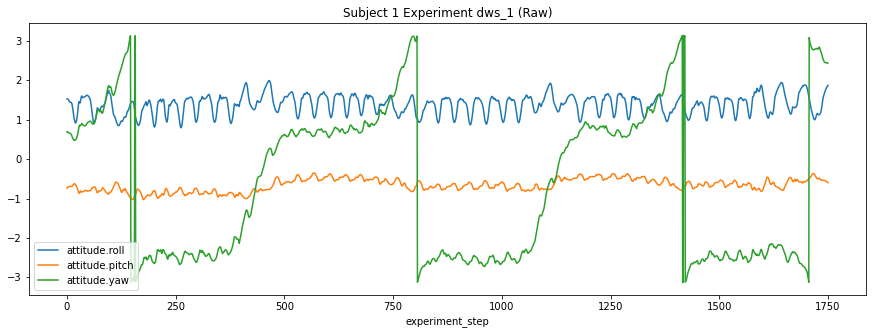

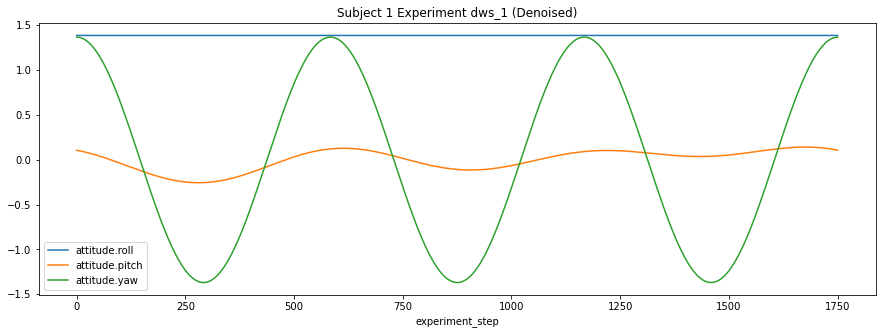

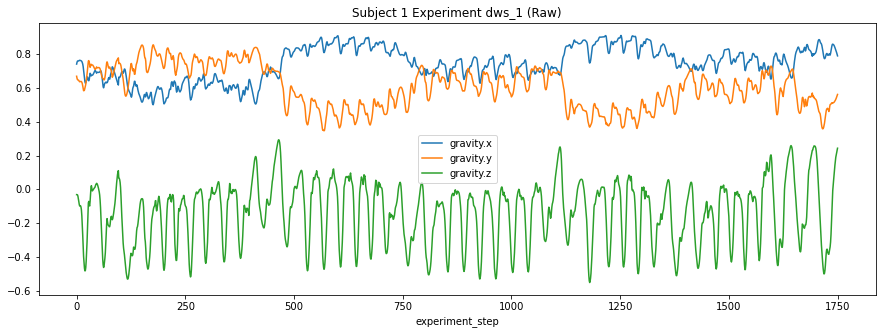

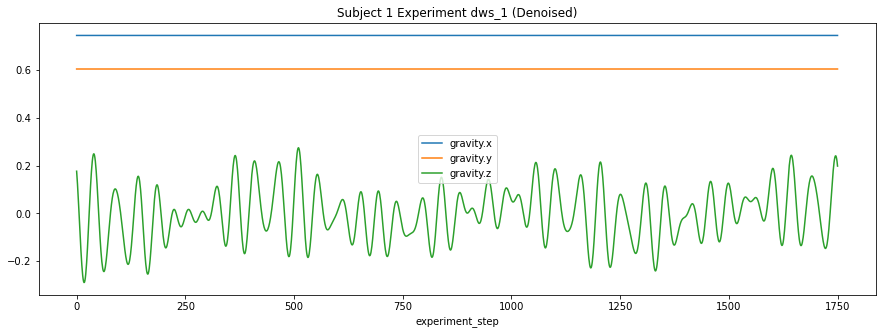

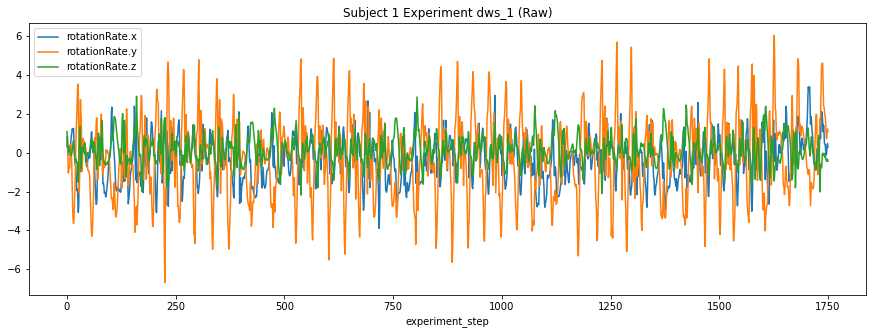

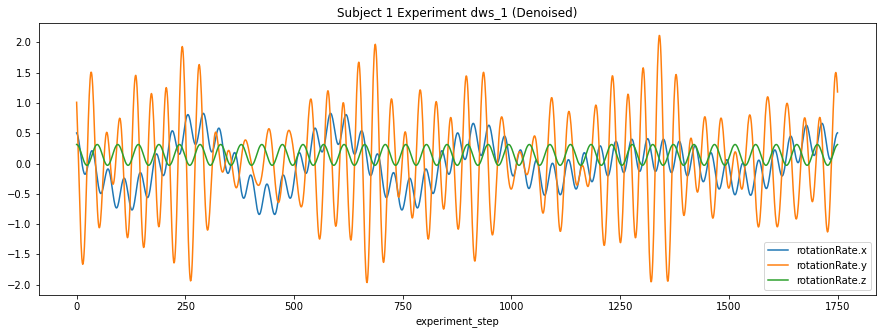

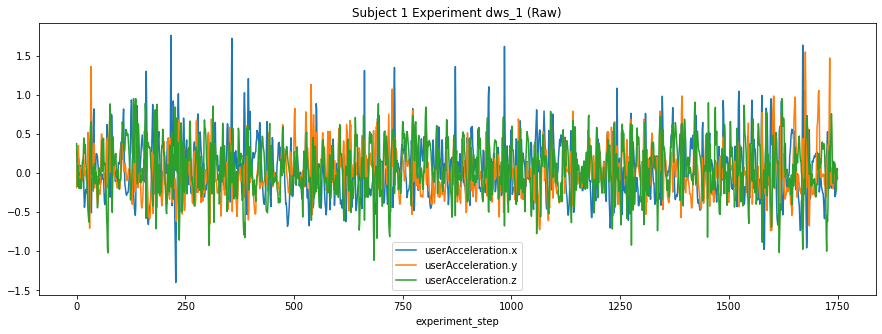

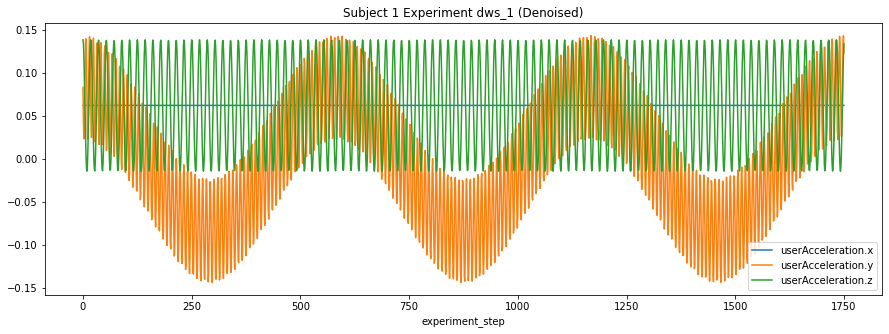

In [8]:
plot_experiment_in_time_domain(raw_df,denoised_df,1,1)

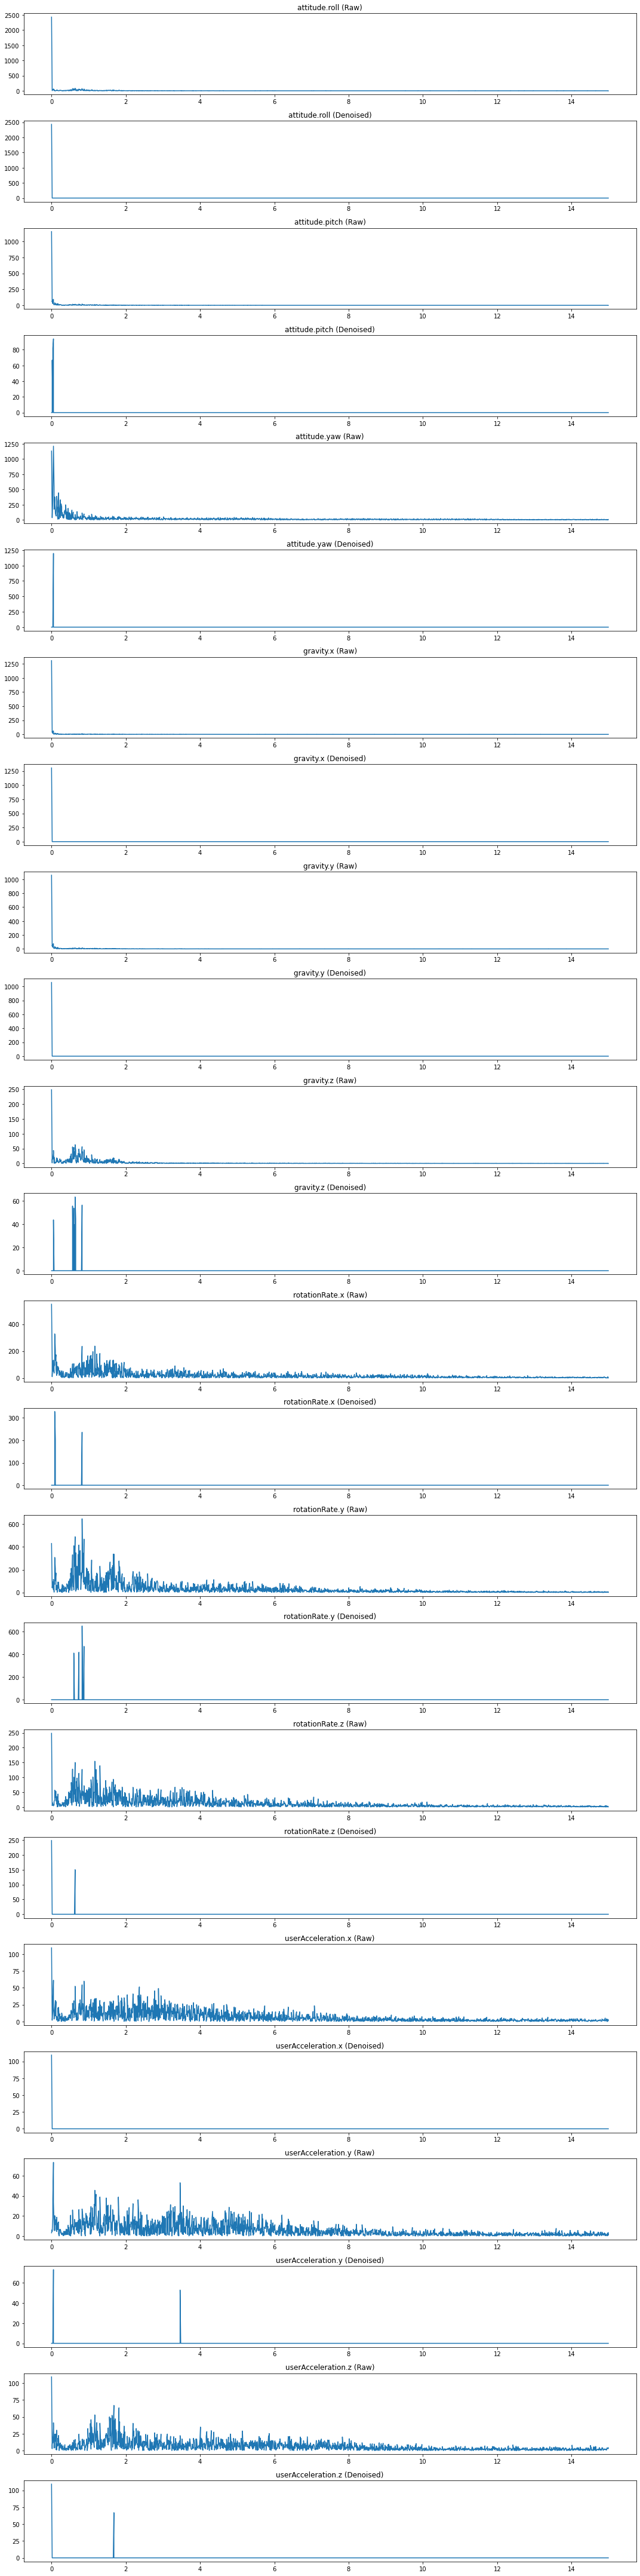

In [9]:
plot_experiment_in_frequency_domain(raw_df, denoised_df, 1, 1)

In [10]:
def extract_freq_feature(series):
    freq_spectrum = rfft(series.to_numpy())
    
    max_amp = np.amax(freq_spectrum)
    main_freq = np.argmax(freq_spectrum)
    num_freq = np.sum(freq_spectrum > 0)
    
    return [max_amp, main_freq, num_freq]

In [18]:
def get_processed_df(df, window_size, step_size, time_features):
    """
    Use sliding windows methods to extract features per experiment and subject
    """
    grouped_df = df.groupby(['subject', 'experiment_id'])
    processed_dfs = []
    for (subject, experiment), data in grouped_df: # iterate over data per subject per experiment

        activity = data.activity.values[0] # all activites in this experiment are the same
        
        windows_list = []
        for start in range(0, len(data) - window_size, step_size):
            end = start + window_size
            values = data[MOTION_SENSOR_COLUMNS].iloc[start : end]
            
            # extract time domain features
            time_feature_table = values.agg(time_features)
            
            window = time_feature_table.unstack().to_frame().T
            window.columns = window.columns.map('_'.join)

            # extract frequency domain features
            for reading in MOTION_SENSOR_COLUMNS:
                freq_features = extract_freq_feature(values[reading])
                window[reading + '_max_amp'] = freq_features[0]
                window[reading + '_main_freq'] = freq_features[1]
                window[reading + '_num_freq'] = freq_features[2]
            
            # add index range
            window['index_range'] = "{}-{}".format(start, end)

            windows_list.append(window)

        if len(windows_list) == 0:
            continue
        
        processed_df = pd.concat(windows_list)
        
        processed_df['activity'] = activity # this will be the label
        processed_df['subject'] = subject
        processed_df['experiment'] = experiment

        processed_dfs.append(processed_df)
    
    processed_data = pd.concat(processed_dfs)
    return processed_data

In [25]:
time_features = ['min', 'max', 'median', 'std', 'skew']
# processed_data = get_processed_df(denoised_df, 100, 25, time_features)
# processed_data = get_processed_df(denoised_df, 100, 50, time_features)
# processed_data = get_processed_df(denoised_df, 200, 50, time_features)
# processed_data = get_processed_df(denoised_df, 200, 100, time_features)
# processed_data = get_processed_df(denoised_df, 300, 75, time_features)
# processed_data = get_processed_df(denoised_df, 300, 150, time_features)

In [26]:
processed_data.columns

Index(['attitude.roll_min', 'attitude.roll_max', 'attitude.roll_median',
       'attitude.roll_std', 'attitude.roll_skew', 'attitude.pitch_min',
       'attitude.pitch_max', 'attitude.pitch_median', 'attitude.pitch_std',
       'attitude.pitch_skew', 'attitude.yaw_min', 'attitude.yaw_max',
       'attitude.yaw_median', 'attitude.yaw_std', 'attitude.yaw_skew',
       'gravity.x_min', 'gravity.x_max', 'gravity.x_median', 'gravity.x_std',
       'gravity.x_skew', 'gravity.y_min', 'gravity.y_max', 'gravity.y_median',
       'gravity.y_std', 'gravity.y_skew', 'gravity.z_min', 'gravity.z_max',
       'gravity.z_median', 'gravity.z_std', 'gravity.z_skew',
       'rotationRate.x_min', 'rotationRate.x_max', 'rotationRate.x_median',
       'rotationRate.x_std', 'rotationRate.x_skew', 'rotationRate.y_min',
       'rotationRate.y_max', 'rotationRate.y_median', 'rotationRate.y_std',
       'rotationRate.y_skew', 'rotationRate.z_min', 'rotationRate.z_max',
       'rotationRate.z_median', 'rotationRa

In [27]:
processed_data.isnull().sum()

attitude.roll_min               0
attitude.roll_max               0
attitude.roll_median            0
attitude.roll_std               0
attitude.roll_skew              0
attitude.pitch_min              0
attitude.pitch_max              0
attitude.pitch_median           0
attitude.pitch_std              0
attitude.pitch_skew             0
attitude.yaw_min                0
attitude.yaw_max                0
attitude.yaw_median             0
attitude.yaw_std                0
attitude.yaw_skew               0
gravity.x_min                   0
gravity.x_max                   0
gravity.x_median                0
gravity.x_std                   0
gravity.x_skew                  0
gravity.y_min                   0
gravity.y_max                   0
gravity.y_median                0
gravity.y_std                   0
gravity.y_skew                  0
gravity.z_min                   0
gravity.z_max                   0
gravity.z_median                0
gravity.z_std                   0
gravity.z_skew

In [28]:
exp_data = processed_data.loc[(processed_data['experiment'] == 1) & (processed_data['subject'] == 1)]
exp_data.head(100)

,attitude.roll_min,attitude.roll_max,attitude.roll_median,attitude.roll_std,attitude.roll_skew,attitude.pitch_min,attitude.pitch_max,attitude.pitch_median,attitude.pitch_std,attitude.pitch_skew,attitude.yaw_min,attitude.yaw_max,attitude.yaw_median,attitude.yaw_std,attitude.yaw_skew,gravity.x_min,gravity.x_max,gravity.x_median,gravity.x_std,gravity.x_skew,gravity.y_min,gravity.y_max,gravity.y_median,gravity.y_std,gravity.y_skew,gravity.z_min,gravity.z_max,gravity.z_median,gravity.z_std,gravity.z_skew,rotationRate.x_min,rotationRate.x_max,rotationRate.x_median,rotationRate.x_std,rotationRate.x_skew,rotationRate.y_min,rotationRate.y_max,rotationRate.y_median,rotationRate.y_std,rotationRate.y_skew,rotationRate.z_min,rotationRate.z_max,rotationRate.z_median,rotationRate.z_std,rotationRate.z_skew,userAcceleration.x_min,userAcceleration.x_max,userAcceleration.x_median,userAcceleration.x_std,userAcceleration.x_skew,userAcceleration.y_min,userAcceleration.y_max,userAcceleration.y_median,userAcceleration.y_std,userAcceleration.y_skew,userAcceleration.z_min,userAcceleration.z_max,userAcceleration.z_median,userAcceleration.z_std,userAcceleration.z_skew,attitude.roll_max_amp,attitude.roll_main_freq,attitude.roll_num_freq,attitude.pitch_max_amp,attitude.pitch_main_freq,attitude.pitch_num_freq,attitude.yaw_max_amp,attitude.yaw_main_freq,attitude.yaw_num_freq,gravity.x_max_amp,gravity.x_main_freq,gravity.x_num_freq,gravity.y_max_amp,gravity.y_main_freq,gravity.y_num_freq,gravity.z_max_amp,gravity.z_main_freq,gravity.z_num_freq,rotationRate.x_max_amp,rotationRate.x_main_freq,rotationRate.x_num_freq,rotationRate.y_max_amp,rotationRate.y_main_freq,rotationRate.y_num_freq,rotationRate.z_max_amp,rotationRate.z_main_freq,rotationRate.z_num_freq,userAcceleration.x_max_amp,userAcceleration.x_main_freq,userAcceleration.x_num_freq,userAcceleration.y_max_amp,userAcceleration.y_main_freq,userAcceleration.y_num_freq,userAcceleration.z_max_amp,userAcceleration.z_main_freq,userAcceleration.z_num_freq,index_range,activity,subject,experiment
0,1.387143,1.387143,1.387143,0.0,0.0,-0.255222,0.107185,-0.125182,0.122344,0.285473,-1.368565,1.368568,-0.052778,0.981846,0.035371,0.745272,0.745272,0.745272,1.112078e-16,0.0,0.604755,0.604755,0.604755,1.112078e-16,0.0,-0.289476,0.249166,-0.021063,0.120976,-0.050972,-0.766900,0.827625,-0.093673,0.433614,0.215801,-1.937262,1.930175,-0.015522,0.973128,-0.003958,-0.029607,0.313414,0.149439,0.120871,-0.049819,0.062493,0.062493,0.062493,6.950488e-18,0.0,-0.143676,0.142455,-0.003927,0.073616,0.009027,-0.014133,0.138854,0.060508,0.054201,0.020175,416.142799,0,1,3.516256,1,150,5.373752,1,150,223.581613,0,1,181.426415,0,1,18.406961,12,152,58.733127,1,148,93.346267,12,151,43.794816,0,144,18.74783,0,1,6.578801,69,122,18.528445,0,151,0-300,dws,1,1
0,1.387143,1.387143,1.387143,0.0,0.0,-0.255222,0.005940,-0.208134,0.077804,0.921881,-1.368565,0.946222,-0.946221,0.730351,0.779794,0.745272,0.745272,0.745272,1.112078e-16,0.0,0.604755,0.604755,0.604755,1.112078e-16,0.0,-0.254018,0.242391,-0.007783,0.104269,-0.079123,-0.766900,0.827625,0.090937,0.437320,-0.088042,-1.937262,1.930175,-0.025462,0.881032,0.031804,-0.029605,0.313413,0.141750,0.120180,0.003496,0.062493,0.062493,0.062493,6.950488e-18,0.0,-0.143676,0.117181,-0.036453,0.062173,0.310806,-0.014133,0.138854,0.060782,0.053999,0.021259,416.142799,0,1,8.989825,1,150,69.501805,1,150,223.581613,0,1,181.426415,0,1,9.771148,16,153,71.063466,2,130,79.754304,17,151,42.483787,0,146,18.74783,0,1,4.340421,1,154,18.462487,0,172,75-375,dws,1,1
0,1.387143,1.387143,1.387143,0.0,0.0,-0.255222,-0.055623,-0.208134,0.055096,0.754068,-1.368565,0.165338,-0.946221,0.447179,0.532995,0.745272,0.745272,0.745272,1.112078e-16,0.0,0.604755,0.604755,0.604755,1.112078e-16,0.0,-0.254018,0.242391,-0.012971,0.104429,0.243286,-0.841200,0.827625,0.090937,0.443218,-0.083559,-1.937262,1.930175,0.003848,0.814278,-0.035699,-0.029605,0.313410,0.136519,0.120711,0.043541,0.062493,0.062493,0.062493,6.950488e-18,0.0,-0.143676,0.06

In [29]:
processed_data.shape

(17580, 100)

In [30]:
# processed_data.to_csv('processed_data_100_25.csv', index=False)
# processed_data.to_csv('processed_data_100_50.csv', index=False)
# processed_data.to_csv('processed_data_200_50.csv', index=False)
# processed_data.to_csv('processed_data_200_100.csv', index=False)
# processed_data.to_csv('processed_data_300_150.csv', index=False)
# processed_data.to_csv('processed_data_300_75.csv', index=False)